<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [2]:
import pandas as pd
url = '../dat/past.csv.gz'
past = pd.read_csv('../dat/past.csv.gz')
# df = pd.read_csv(url, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?   

    *34% of the interactions resulted in purchase.*

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?

    *65% of the people do not complete the purchase ("window shopping") while 35% do.*
    
    From the perspective of classification, is the data balanced?

    *The two classes (purchased and not purchased) have 35% and 65% of the data points respectively. Typically, it is expected that purchases are less than non-purchases. This is why the specific data could be considered as slightly but not significantly imbalanced.*

In [3]:
# past['Purchased?'].value_counts() / past.shape[0] # YOUR CODE HERE
past['Purchased?'].value_counts(normalize=True) # YOUR CODE HERE
# past.describe()
# past.head(5)


0    0.6562
1    0.3438
Name: Purchased?, dtype: float64

3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [4]:
X = past.drop(columns=['product_id','user_id'])# YOUR CODE HERE
y = X.pop('Purchased?') 

In [5]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [6]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X) # YOUR CODE HERE
assert X_scaled.shape == (5000, 34)
pca = PCA(n_components=5) 
pca = pca.fit(X_scaled)
X_reduced = pca.transform(X_scaled) 
# X_reduced = pca.fit_transform(X_scaled) # YOUR CODE HERE

In [7]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [8]:

pca.explained_variance_ratio_ # YOUR CODE HERE

array([0.10282272, 0.09445537, 0.06515499, 0.05122352, 0.04230143])

6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [9]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [10]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

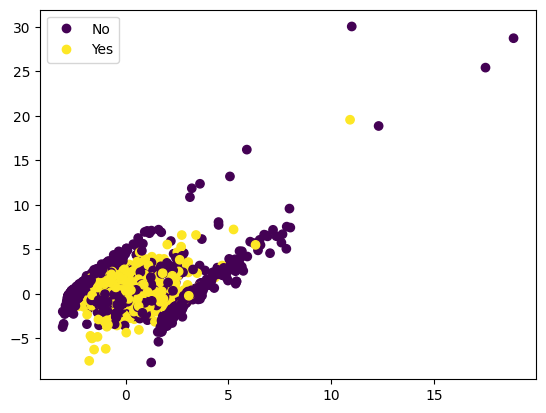

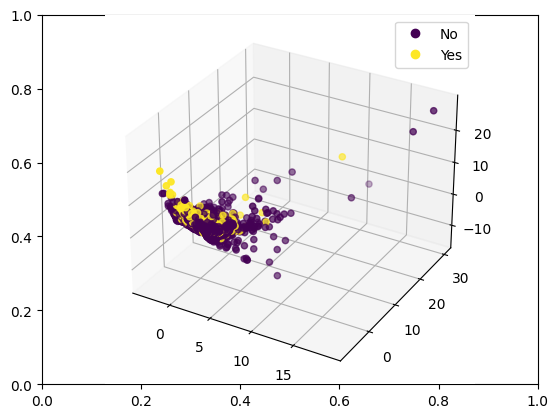

In [11]:
visualize_2pcs(X_reduced,y) # YOUR CODE HERE
visualize_3pcs(X_reduced,y) # YOUR CODE HERE


7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [12]:
# YOUR CODE HERE (imports!)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

def train(X, y, standardize = True) -> None:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if standardize:
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('logistic_regression', LogisticRegression(class_weight='balanced'))]).fit(X_train, y_train)
    else:
        pipeline = Pipeline(steps=[('logistic_regression', LogisticRegression(class_weight='balanced'))]).fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))


Now apply the pipeline on the all the features `X` and review the performance

In [13]:
train(X, y) # YOUR CODE HERE

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       659
           1       0.54      0.53      0.54       341

    accuracy                           0.69      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.69      0.69      0.69      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [14]:
train(X_reduced, y, standardize=False)# YOUR CODE HERE

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       659
           1       0.49      0.52      0.51       341

    accuracy                           0.66      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.66      0.66      0.66      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 

*The classification results are similar, pointing to a successful dimensionality reduction. Reducing the number of feature while maintaining quality results improves the computational efficiency. Visualization is easier, especially when you can visualize the most "important" data. Quality of results is increased by reduction of noise through the removal of redundant features. Working with lower data dimensionality is easier. On the contrary, cons of dimensionality reduction may be loss of information, over-simplification and not capturing well non-linear relationships between features.*

*Looking into the specific initial dataset, there are columns that look similar/correlated to each other. For example, columns "NumOfEventsInJourney" and "NumSessions" seem strongly correlated to each other; "maxPrice" & "minPrice" as well. Dimensionality reduction in this case can help reduce redundancy, improve computational effort and interpretability while achieving, at the same time, quality results.*

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [15]:
from sklearn.cluster import KMeans  # YOUR CODE HERE

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [16]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        inertias.append(kmeans.inertia_) # YOUR CODE HERE
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

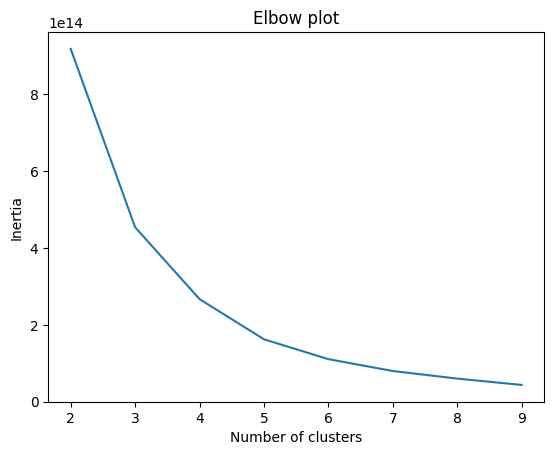

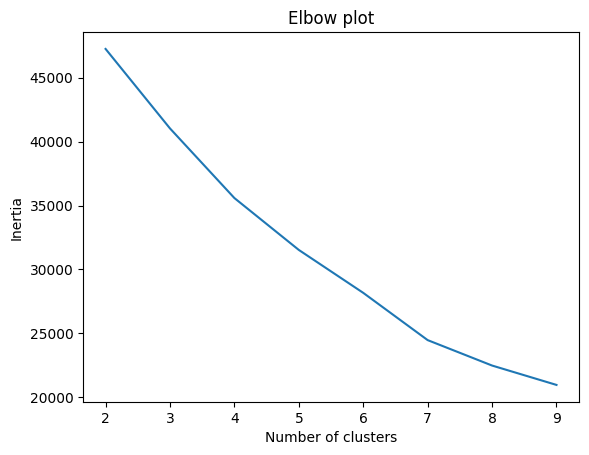

In [17]:
visualize_elbow(X, [2,3,4,5,6,7,8,9]) # YOUR CODE HERE
visualize_elbow(X_reduced, [2,3,4,5,6,7,8,9]) # YOUR CODE HERE

4. What are the disadvantage to use the Elbow method? 

In the case of reduced data it is not clear where exactly the Elbow of the curve is.

Still, for the initial data we see that there are points - at 3, 4, 5 clusters - that kinks are formed in the graph. Which backs up our choice of 5 principal components in the PCA. 

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [18]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.2528308937559011
For n_clusters = 3 The average silhouette_score is : 0.26128007615572907
For n_clusters = 4 The average silhouette_score is : 0.2752344625327015
For n_clusters = 5 The average silhouette_score is : 0.30723989080073355
For n_clusters = 6 The average silhouette_score is : 0.24546813790256475
For n_clusters = 7 The average silhouette_score is : 0.25215406305221805
For n_clusters = 8 The average silhouette_score is : 0.2563190167157854


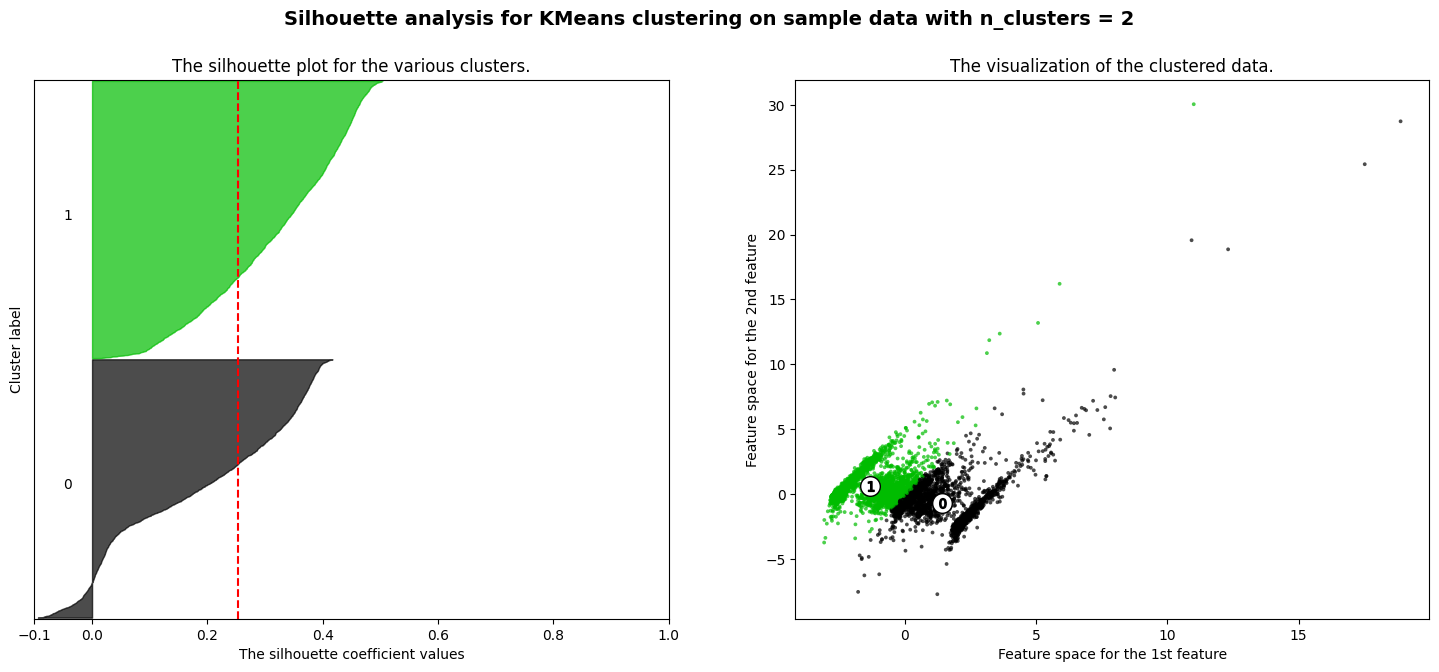

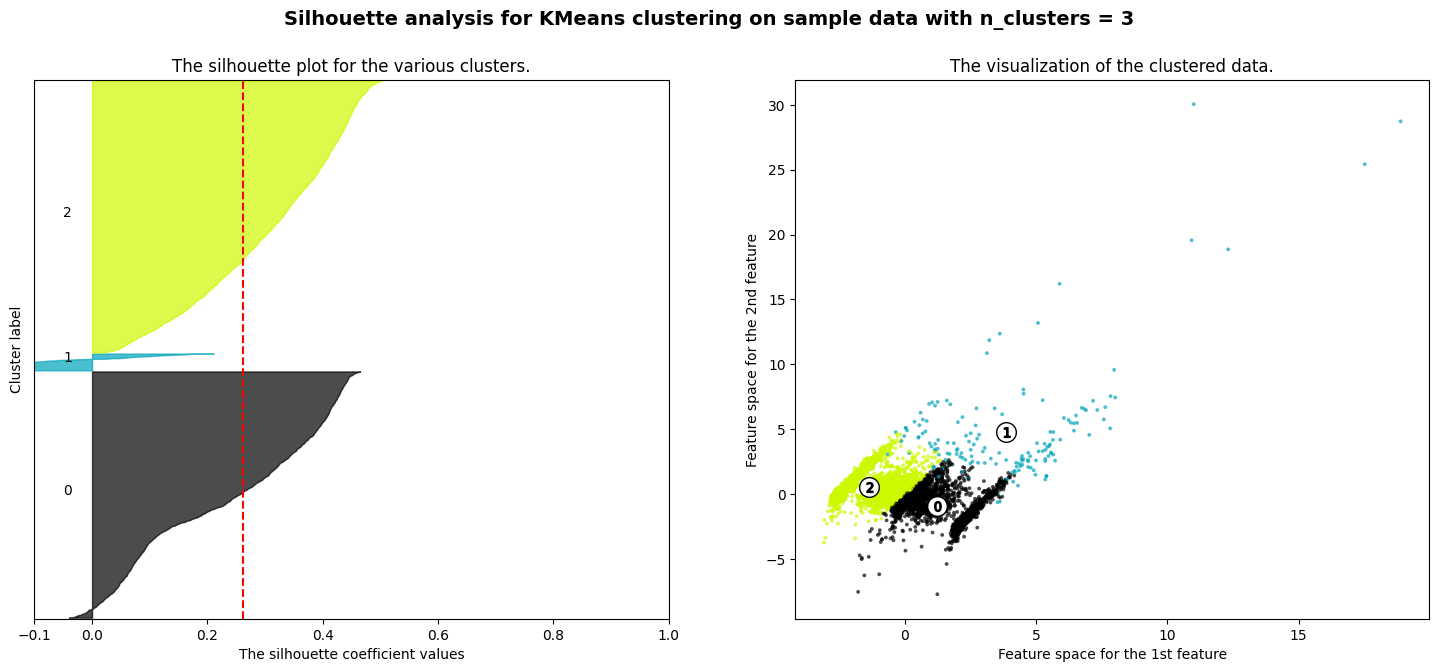

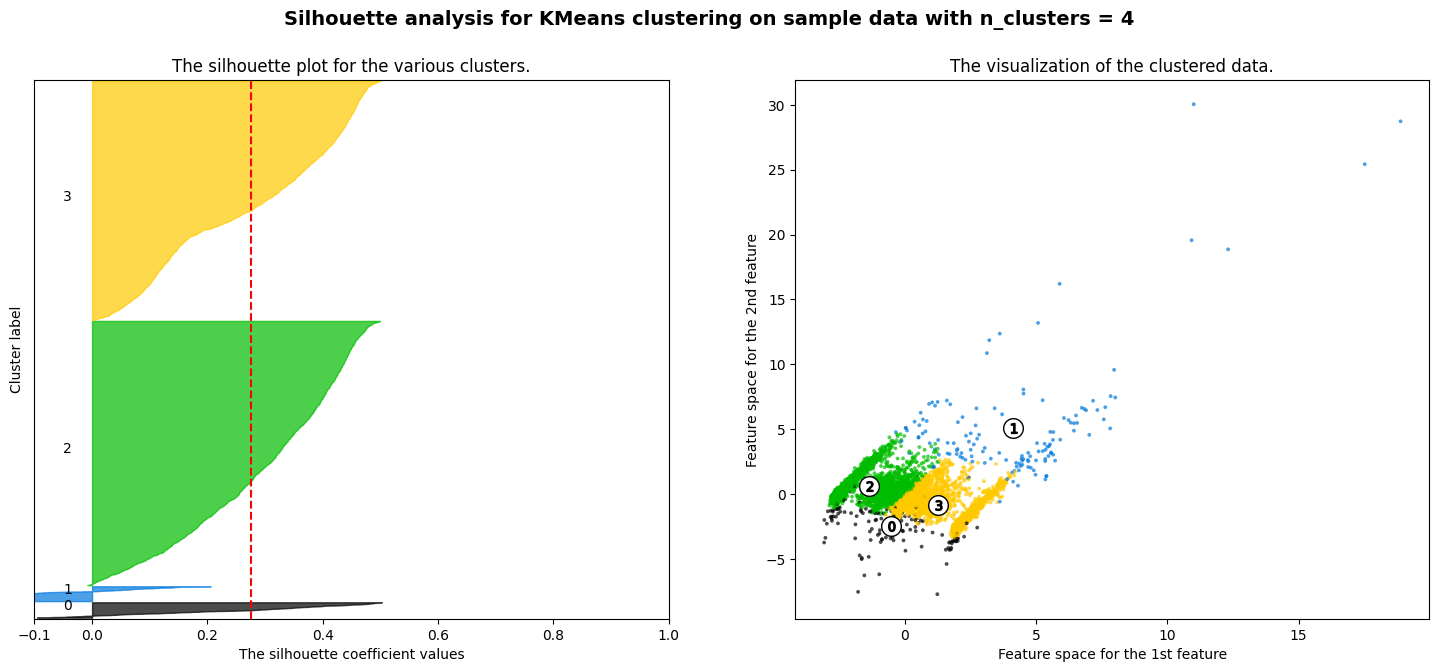

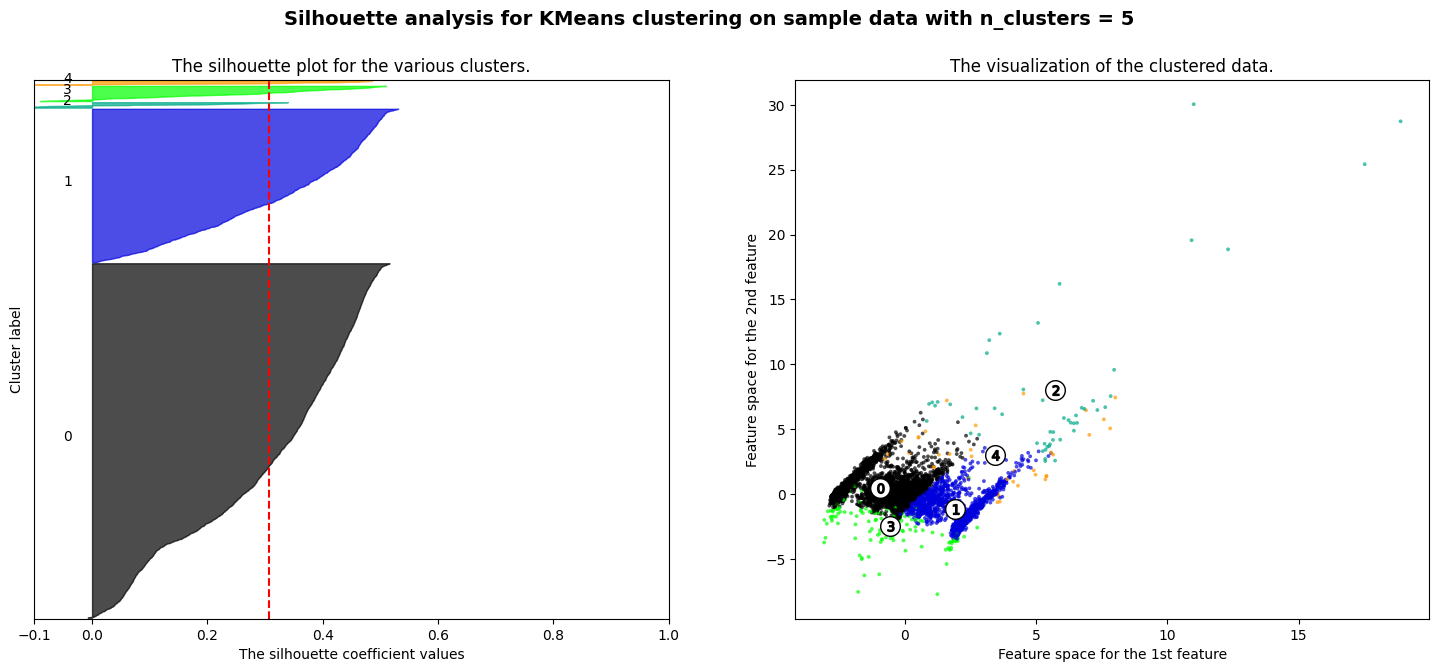

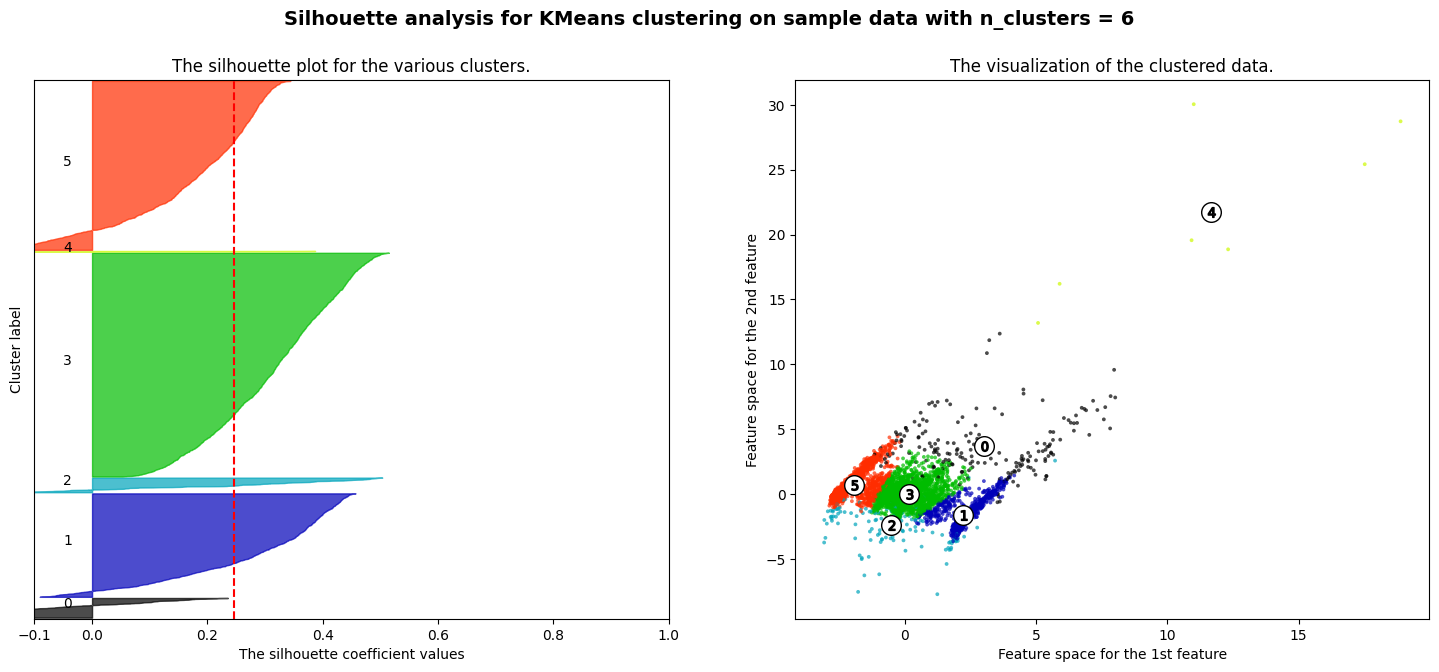

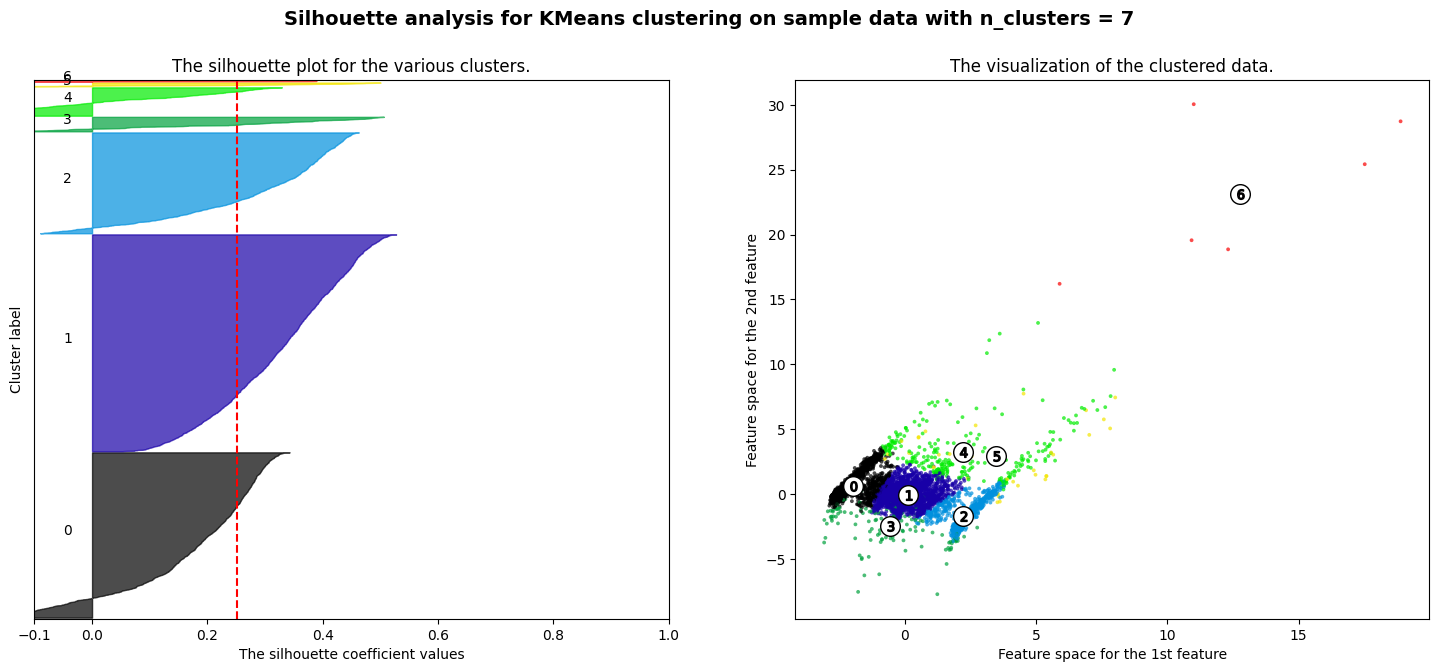

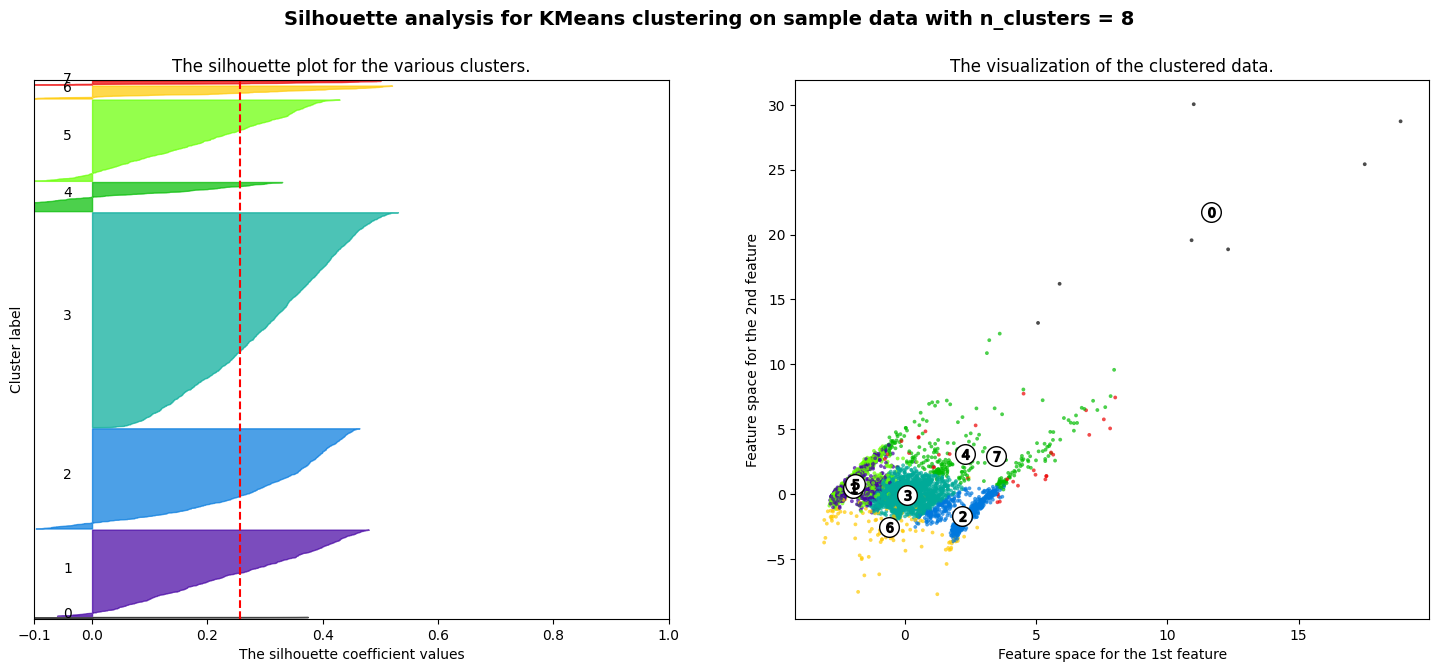

In [19]:
visualize_silhouette(8, X_reduced, random_state=10) # YOUR CODE HERE

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [27]:
km = 4
kmeans = KMeans(n_clusters=km, random_state=10).fit(X_reduced) # YOUR CODE HERE
kmeans

KMeans(n_clusters=4, random_state=10)

7. What is the size of each cluster? 
*Cluster 0: 145
Cluster 1: 140
Cluster 2: 2476
Cluster 3: 2239*

In [32]:
import numpy as np
for k in range(km):
    print(f'Cluster {k}: {np.bincount(kmeans.labels_)[k]}') # YOUR CODE HERE

Cluster 0: 145
Cluster 1: 140
Cluster 2: 2476
Cluster 3: 2239


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [35]:
past['cluster_pca'] = kmeans.labels_ # YOUR CODE HERE

9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

    * Once we have our clusters, we can treat each individual cluster as a unique dataset. We can apply feature engineering, descriptive statistic, even ML algorithms on each individual dataset. For example, we can calculate moments of each cluster, plot the distributions, calculate quantiles, probabilities, etc, and look for correlations.*

In [122]:
cluster_zero = past[past["cluster_pca"] == 0]
cluster_zero.describe()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,1.450000e+02,1.450000e+02,145.000000,145.000000,1.450000e+02,145.000000,145.000000,145.000000,145.000000,145.000000,...,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.0
mean,5.478166e+06,5.349068e+08,1.455520,1.178449,9.665701e+04,59.285213,59.237057,0.120745,1.227293,0.072131,...,0.227166,0.058059,0.196941,0.188745,0.181382,0.062465,0.420690,0.085243,1.055141,0.0
std,1.410066e+06,5.461026e+07,0.642227,0.282797,2.043674e+05,33.332473,33.323856,0.222806,0.412881,0.182627,...,0.243647,0.144215,0.247469,0.226821,0.244706,0.147342,0.495381,0.191753,0.182309,0.0
min,5.379000e+03,1.439953e+08,1.000000,1.000000,0.000000e+00,30.160000,30.160000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.0
25%,5.774248e+06,5.140388e+08,1.000000,1.000000,0.000000e+00,38.890000,38.890000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,5.864034e+06,5.463438e+08,1.300000,1.066667,5.080000e+02,46.670000,46.490000,0.000000,1.125000,0.000000,...,0.200000,0.000000,0.135135,0.135135,0.132530,0.000000,0.000000,0.000000,1.000000,0.0
75%,5.892732e+06,5.660707e+08,1.684211,1.285714,1.275135e+05,63.372373,63.330000,0.183673,1.346154,0.034483,...,0.333333,0.066667,0.277778,0.291667,0.250000,0.072289,1.000000,0.072289,1.034483,0.0
max,5.931773e+06,6.151285e+08,6.200000,3.000000,1.299567e+06,236.510000,236.510000,1.500000,4.400000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.500000,0.0


In [123]:
cluster_one = past[past["cluster_pca"]==1]
cluster_one.describe()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,1.400000e+02,1.400000e+02,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.0
mean,5.795644e+06,5.019479e+08,5.634179,3.030534,2.358103e+06,4.764817,4.527407,1.594564,1.976622,1.903086,...,0.210919,0.079959,0.134300,0.281150,0.109720,0.119781,0.178571,0.064172,2.110982,1.0
std,4.905627e+05,7.769724e+07,5.035446,3.272330,2.496402e+06,5.465761,5.499278,1.406147,3.769767,3.319891,...,0.344147,0.227456,0.282343,0.388833,0.266692,0.285136,0.384368,0.214384,1.203347,0.0
min,8.919000e+04,1.319941e+08,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,5.803104e+06,4.673728e+08,3.000000,1.935526,4.456851e+05,1.590000,1.430000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
50%,5.850400e+06,5.176398e+08,4.619048,2.000000,1.473292e+06,3.865000,3.331667,1.000000,0.666667,1.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.0
75%,5.889251e+06,5.488989e+08,6.026316,3.000000,3.770195e+06,5.730000,5.560000,2.000000,2.233333,2.000000,...,0.333333,0.000000,0.025000,0.500000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0
max,5.931329e+06,6.100017e+08,40.000000,28.000000,1.087537e+07,51.080000,51.080000,12.000000,28.000000,38.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.0


In [124]:
cluster_two = past[past["cluster_pca"]==2]
cluster_two.describe()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,2.476000e+03,2.476000e+03,2476.000000,2476.000000,2.476000e+03,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,...,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.0
mean,5.546644e+06,5.152552e+08,1.881311,1.286961,1.802613e+05,5.588630,5.568300,0.537297,0.845416,0.393293,...,0.207298,0.067504,0.165684,0.239275,0.174962,0.088243,0.352989,0.057034,1.127689,2.0
std,1.198776e+06,5.891333e+07,0.848971,0.384105,3.931572e+05,5.044059,5.040520,0.534943,0.528737,0.494224,...,0.271217,0.175673,0.252666,0.290384,0.259834,0.197725,0.477996,0.149562,0.399147,0.0
min,4.104000e+03,6.524181e+07,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,5.747406e+06,4.939372e+08,1.000000,1.000000,0.000000e+00,2.380000,2.380000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.0
50%,5.822790e+06,5.283447e+08,1.800000,1.166667,3.103125e+03,4.130000,4.116127,0.500000,1.000000,0.250000,...,0.125000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,1.000000,2.0
75%,5.862716e+06,5.561113e+08,2.285714,1.465805,1.756372e+05,6.750000,6.670000,0.833333,1.000000,0.666667,...,0.333333,0.043478,0.250000,0.333333,0.250000,0.090909,1.000000,0.035714,1.000000,2.0
max,5.916644e+06,5.950013e+08,7.500000,4.000000,3.891687e+06,32.970000,32.970000,4.000000,4.333333,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.0


(array([15., 30., 16., 16., 14., 22.,  4.,  4.,  4.,  6.,  0.,  0.,  0.,
         2.,  3.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.    ,  1.0216,  2.0432,  3.0648,  4.0864,  5.108 ,  6.1296,
         7.1512,  8.1728,  9.1944, 10.216 , 11.2376, 12.2592, 13.2808,
        14.3024, 15.324 , 16.3456, 17.3672, 18.3888, 19.4104, 20.432 ,
        21.4536, 22.4752, 23.4968, 24.5184, 25.54  , 26.5616, 27.5832,
        28.6048, 29.6264, 30.648 , 31.6696, 32.6912, 33.7128, 34.7344,
        35.756 , 36.7776, 37.7992, 38.8208, 39.8424, 40.864 , 41.8856,
        42.9072, 43.9288, 44.9504, 45.972 , 46.9936, 48.0152, 49.0368,
        50.0584, 51.08  ]),
 <BarContainer object of 50 artists>)

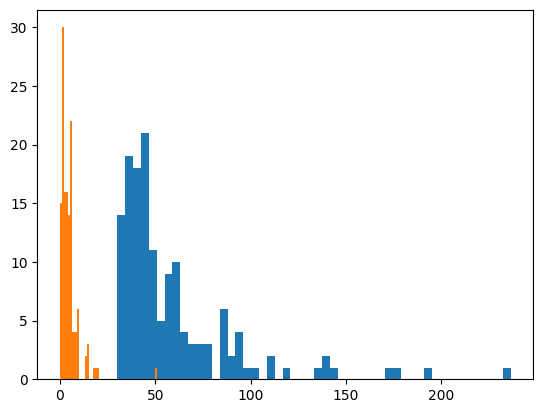

In [128]:
plt.hist(cluster_zero.maxPrice, 50)
plt.hist(cluster_one.maxPrice, 50)

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

    *YOUR ANSWER HERE*

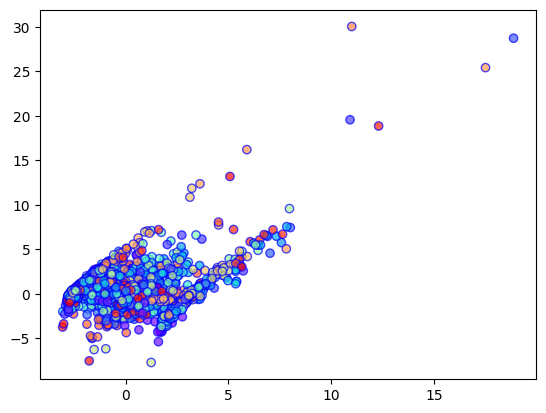

In [126]:
# YOUR CODE HERE
from sklearn.cluster import AffinityPropagation
# sc = SpectralClustering(n_clusters=4, n_init=100, assign_labels='discretize')
# sc.fit_predict(X_reduced)  
clustering = AffinityPropagation(random_state=0)
clustering.fit_predict(X_reduced)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')

11. Jot down recommendations or followup steps, detailing the reasons.

    *Follow up steps after implementing other clustering algorithms, similar to k-means clustering, include tuning to find the best representative number of clusters. This can be accomplished with various different methods such as the Silhoutte visualization above. Reasons for finding the optimal number of clusters include: you do not want your algorithm to be overtrained with too many clusters and too fine granularity, nor do you want too few clusters where the model is lacking in accuracy, as the difference in loss will be greater between the actual ground truth and the predicted values.*

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [36]:
new = pd.read_csv('../dat/new.csv.gz') # YOUR CODE HERE

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


In [37]:
assert new.shape == (30091, 5)

In [42]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

*The number of datapoints in the training set is relatively small compared to the much larger test set. The training set also has signicantly more features than the test set.*

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [44]:
# YOUR CODE HERE
np.intersect1d(new['product_id'].unique(), past['product_id'].unique()).shape

(0,)

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [48]:
# YOUR CODE HERE # ~.344
new['Purchased?'].value_counts(normalize=True)

0    0.655744
1    0.344256
Name: Purchased?, dtype: float64

5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [84]:
# YOUR CODE HERE
X_train = past.drop(columns=['product_id','user_id'])
X_train = X_train[['maxPrice','minPrice','Category','Purchased?']]
y_train = X_train.pop('Purchased?') 

X_test = new.drop(columns=['product_id'])
y_test = X_test.pop('Purchased?')

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [85]:
import numpy as np
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [87]:
# YOUR CODE HERE
# from sklearn import 
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('logistic_regression', LogisticRegression(class_weight='balanced'))]).fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [95]:
# YOUR CODE HERE
X = np.concatenate((X_train, X_test))

In [96]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [112]:
# YOUR CODE HERE
y = np.concatenate((y_train, np.negative(np.ones(y_test.shape))))

In [105]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [113]:
# YOUR CODE HERE
from sklearn.semi_supervised import LabelSpreading

label_spread_model = LabelSpreading(kernel='knn',alpha=0.001).fit(X, y)
label_spread_model

LabelSpreading(alpha=0.001, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [118]:
semi_sup_preds = label_spread_model.transduction_ # YOUR CODE HERE
semi_sup_preds = semi_sup_preds[-y_test.shape[0]:] 

In [119]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [120]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     19732
           1       0.81      0.62      0.70     10359

    accuracy                           0.82     30091
   macro avg       0.82      0.77      0.78     30091
weighted avg       0.82      0.82      0.81     30091



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



    *Semi-supervised learning benefits from allowing the model to learn from smaller datasets. This can be accomplished through the label spreading method as mentioned aboved, "label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data." For example, the clusters above may benefit from semi-supervised learning if only 3 of the 50 elements in the cluster are labelled, the other 47 unlabeled elements in the same cluster could be categorized to the same label with some increased degree of accuracy.*

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)